# ML Model
In this notebook, the data is used to create a machine-learning model that predicts the primary collision factor. The models used were categorical ensemble models that were trained on the data for individuals at fault. The three models considered were evaluated using accuracy, recall, precision, and f1 score. The hyperparameters for the final model were tuned using GridSearchCV. The data was not once hot encoded to see the importance of every feature in the model. The features with the least importance were dropped and the model was trained and evaluated on the new data. Given the size of the data, each grid search took a couple of hours even on a validation set. Therefore, there was only a course and refined search for the best parameters. The model was exported to be deployed on a web app and then called back to be tested in this notebook.

In [1]:
# import all libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import dump
from joblib import load
from sklearn.model_selection import GridSearchCV

In [3]:
# import clean data for collisions at fault
data = pd.read_parquet('at_fault_collisions.parquet')

In [3]:
# verify data
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1401155 entries, 0 to 3082219
Data columns (total 48 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   CASE_ID               1401155 non-null  int64   
 1   PARTY_SEX             1401155 non-null  category
 2   PARTY_AGE             1401155 non-null  int64   
 3   PARTY_SOBRIETY        1401155 non-null  category
 4   PARTY_DRUG_PHYSICAL   1401155 non-null  category
 5   DIR_OF_TRAVEL         1401155 non-null  category
 6   PARTY_SAFETY_EQUIP_1  1401155 non-null  category
 7   PARTY_SAFETY_EQUIP_2  1401155 non-null  category
 8   FINAN_RESPONS         1401155 non-null  category
 9   SP_INFO_2             1401155 non-null  category
 10  OAF_VIOL_CAT          1401155 non-null  category
 11  OAF_1                 1401155 non-null  category
 12  MOVE_PRE_ACC          1401155 non-null  category
 13  VEHICLE_YEAR          1401155 non-null  int64   
 14  VEHICLE_MAKE          1

#### Feature Selection

In [4]:
# drop columns not needed based on data visualizations done on Tableau
cols_to_drop = ['CASE_ID','PARTY_SAFETY_EQUIP_2','SP_INFO_2','OAF_1','BEAT_TYPE',
                'CHP_VEH_TYPE_TOWING', 'PRIMARY_COLL_FACTOR', 'DIRECTION']

data = data.drop(cols_to_drop, axis = 1)

In [5]:
# reset index
data = data.reset_index(drop = True)

#### Data Preprocessing
Since feature importance is a large area of interest, categorical values will not be one hot encoded. Instead, categorial labels will be label encoded. At this point, I decided to keep 'Not Stated' values in the target because it would be interesting to see if there is any correlation between a PCF category not being stated to any of the features. I decided not to scale numerical values as that would make it more challenging to enter into the user interface later in the project.

In [6]:
# label encode categorical columns

# select categorical dtypes
cat_cols = data.select_dtypes(include = ['category']).columns

encoder_mappings = {}

# fit and transform
for col in cat_cols:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
    #save mapping of encoded values
    encoder_mappings[col] = encoder.classes_

# copy the data frame 
processed_data = data.copy()


In [46]:
# check mapping
encoder_mappings['PCF_VIOL_CATEGORY'][:]

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '21', '22', 'Not Stated'],
      dtype=object)

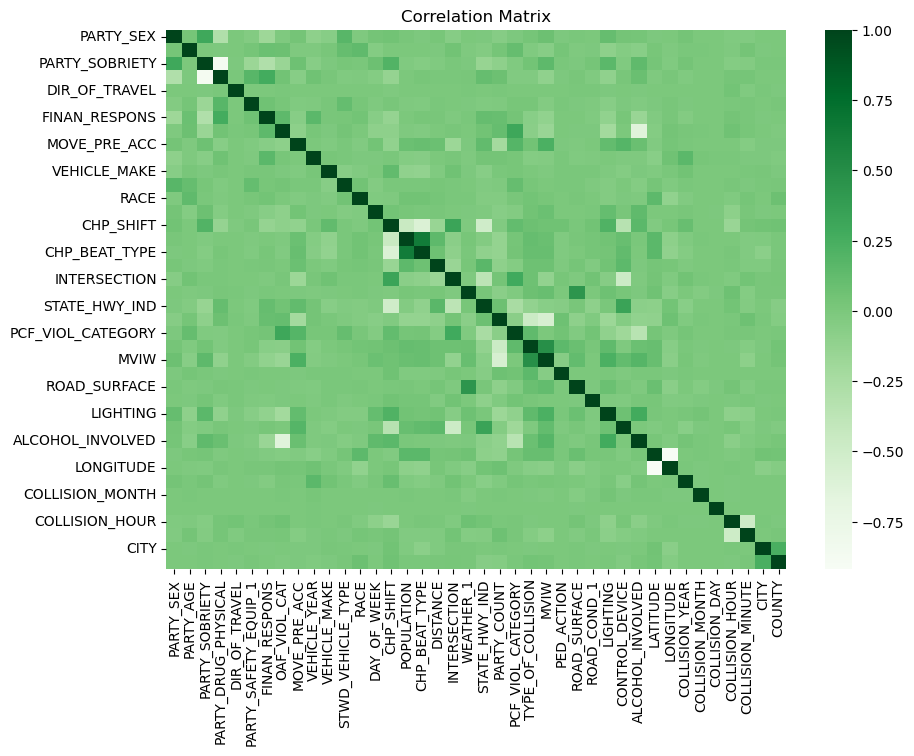

In [53]:
# view correlations of columns
corr_mtx = processed_data.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_mtx, fmt="d", cmap="Greens")
plt.title('Correlation Matrix')
plt.show()

In [7]:
# create target and features
y = processed_data['PCF_VIOL_CATEGORY']
X = processed_data.drop('PCF_VIOL_CATEGORY', axis = 1)

In [9]:
# check for class imbalance
class_distribution = processed_data['PCF_VIOL_CATEGORY'].value_counts()
print(class_distribution)

class_percentage = processed_data['PCF_VIOL_CATEGORY'].value_counts(normalize=True) * 100
print(class_percentage)

PCF_VIOL_CATEGORY
3     531007
8     314758
1     148524
9     124753
7     113330
12     56953
18     35439
5      18078
4      14552
6      11209
17      8696
10      7531
19      5552
0       4068
16      2036
13      1753
20      1725
2        803
11       263
15        80
14        45
Name: count, dtype: int64
PCF_VIOL_CATEGORY
3     37.897806
8     22.464181
1     10.600112
9      8.903583
7      8.088327
12     4.064718
18     2.529270
5      1.290221
4      1.038572
6      0.799983
17     0.620631
10     0.537485
19     0.396245
0      0.290332
16     0.145309
13     0.125111
20     0.123113
2      0.057310
11     0.018770
15     0.005710
14     0.003212
Name: proportion, dtype: float64


There is a class imbalance that has to be taken into consideration when looking at the metrics for each model. I attempted to resample the data to balance the classes but that resulted in a low performing model all around. So, when metrics are assessed recall, precision and f1 scores will be reviewed more carefully than accuracy. 

## Baseline Model Selection

### Random Forest Classifier

In [14]:
# instanciate object
rfc_model = RandomForestClassifier(random_state = 42)

# fit data
rfc_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# create predictions for RF
preds = rfc_model.predict(X_test)

In [19]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average = 'weighted', zero_division=1)
recall = recall_score(y_test, preds, average = 'weighted', zero_division=1)
f1 = f1_score(y_test, preds, average = 'weighted', zero_division=1)

print(f'Random Forest: \n Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n F1: {f1}')

Random Forest: 
 Accuracy: 0.8418055104538755 
 Precision: 0.8358022893915624 
 Recall: 0.8418055104538755 
 F1: 0.830360741176589


In [57]:
# save trained model
dump(rfc_model, 'rfc_model.joblib')

['rfc_model.joblib']

In [10]:
# import RF model
rfc_model = load('rfc_model.joblib')

In [20]:
# create confusion matrix to plot
conf_matx = confusion_matrix(y_test, preds)

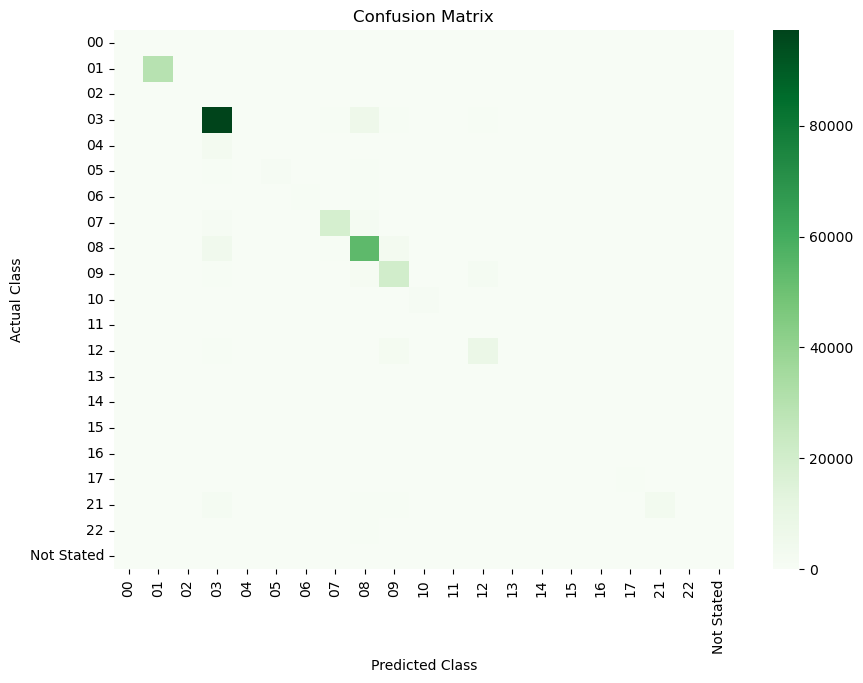

In [44]:
# labels for the classes
class_names = ['00','01','02','03','04','05','06','07','08','09',
               '10','11','12','13','14','15','16','17','21','22','Not Stated'] 

#plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matx, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

### Gradient Boosting Classifier

In [47]:
# instanciate object 
gb_clf = GradientBoostingClassifier(random_state = 42)

#fit model
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [50]:
# predict with gb
gb_preds = gb_clf.predict(X_test)

In [54]:
# rfc evaluation metrics
accuracy_gb = accuracy_score(y_test, gb_preds)
precision_gb = precision_score(y_test, gb_preds, average = 'weighted', zero_division=1)
recall_gb = recall_score(y_test, gb_preds, average = 'weighted', zero_division=1)
f1_gb = f1_score(y_test, gb_preds, average = 'weighted', zero_division=1)

print(f'Gradient Boosting: \n Accuracy: {accuracy_gb} \n Precision: {precision_gb} \n Recall: {recall_gb} \n F1: {f1_gb}')

Gradient Boosting: 
 Accuracy: 0.8310750773469031 
 Precision: 0.8192782906604045 
 Recall: 0.8310750773469031 
 F1: 0.8210730787974866


In [58]:
# save gb model
dump(gb_clf, 'gb_clf.joblib')

['gb_clf.joblib']

In [11]:
# import GB model
gb_clf = load('gb_clf.joblib')

### Voting Classifier

In [49]:
# choose classifiers
clf1 = RandomForestClassifier(random_state = 42)
clf2 = GradientBoostingClassifier(random_state = 42)

# instanciate voting class
voting_clf = VotingClassifier(estimators = [('rfc', clf1), ('gbc', clf2)], voting='soft')

# fit model
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=42)),
                             ('gbc',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [53]:
# predict with voting clf
voting_preds = voting_clf.predict(X_test)

In [55]:
# voting evaluation metrics
accuracy_vt = accuracy_score(y_test, voting_preds)
precision_vt = precision_score(y_test, voting_preds, average = 'weighted', zero_division=1)
recall_vt = recall_score(y_test, voting_preds, average = 'weighted', zero_division=1)
f1_vt = f1_score(y_test, voting_preds, average = 'weighted', zero_division=1)

print(f'Voting: \n Accuracy: {accuracy_vt} \n Precision: {precision_vt} \n Recall: {recall_vt} \n F1: {f1_vt}')

Voting: 
 Accuracy: 0.8400962063440519 
 Precision: 0.8302189783975074 
 Recall: 0.8400962063440519 
 F1: 0.8294806213458189


In [68]:
# save voting model
dump(voting_clf, 'voting_clf.joblib')

['voting_clf.joblib']

In [12]:
# import voting model
voting_clf = load('voting_clf.joblib')

Random Forest looks to be the most promising model with a higher accuracy and F1 score. Despite having imbalanced classes, all three models had good precision and recall scores. The hyperparameters for random forest will be tuned next then check for feature importance to assess whether some features can be dropped.

### Hypertuning Random Forest Classifier Parameters

In [13]:
# create a validation set and maintain class distribution
X_train_red, X_val, y_train_red, y_val = train_test_split(X_train, y_train, test_size = .30, stratify = y_train, random_state = 42)

In [88]:
# Coarse Hyper Parameter Tuning
# create dictionary for parameters
param_grid = {'max_depth': [6,16,32],
              'n_estimators': [10,90,300],
              'min_samples_split':[4,6,8]
             }
grid_search_cv_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid, verbose=5, cv=3)
%time grid_search_cv_rf.fit(X_val, np.array(y_val).flatten())
print("The best parameters are: ", grid_search_cv_rf.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END max_depth=6, min_samples_split=4, n_estimators=10;, score=0.775 total time=   2.5s
[CV 2/3] END max_depth=6, min_samples_split=4, n_estimators=10;, score=0.772 total time=   2.7s
[CV 3/3] END max_depth=6, min_samples_split=4, n_estimators=10;, score=0.776 total time=   2.5s
[CV 1/3] END max_depth=6, min_samples_split=4, n_estimators=90;, score=0.772 total time=  19.8s
[CV 2/3] END max_depth=6, min_samples_split=4, n_estimators=90;, score=0.771 total time=  20.0s
[CV 3/3] END max_depth=6, min_samples_split=4, n_estimators=90;, score=0.771 total time=  20.0s
[CV 1/3] END max_depth=6, min_samples_split=4, n_estimators=300;, score=0.770 total time= 1.1min
[CV 2/3] END max_depth=6, min_samples_split=4, n_estimators=300;, score=0.771 total time= 1.1min
[CV 3/3] END max_depth=6, min_samples_split=4, n_estimators=300;, score=0.772 total time= 1.1min
[CV 1/3] END max_depth=6, min_samples_split=6, n_estimators=10;, score=0

In [90]:
# Refined Hyper Parameter Tuning
# create dictionary for parameters
param_grid = {'max_depth': [25,32,40],
              'n_estimators': [300,400,500],
              'min_samples_split':[3,4,5]
             }
grid_search_cv_rf2 = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid, verbose=5, cv=2)
%time grid_search_cv_rf2.fit(X_val, np.array(y_val).flatten())
print("The best parameters are: ", grid_search_cv_rf2.best_params_)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END max_depth=25, min_samples_split=3, n_estimators=300;, score=0.830 total time= 2.8min
[CV 2/2] END max_depth=25, min_samples_split=3, n_estimators=300;, score=0.832 total time= 2.8min
[CV 1/2] END max_depth=25, min_samples_split=3, n_estimators=400;, score=0.829 total time= 3.7min
[CV 2/2] END max_depth=25, min_samples_split=3, n_estimators=400;, score=0.832 total time= 3.7min
[CV 1/2] END max_depth=25, min_samples_split=3, n_estimators=500;, score=0.830 total time= 4.6min
[CV 2/2] END max_depth=25, min_samples_split=3, n_estimators=500;, score=0.832 total time= 4.6min
[CV 1/2] END max_depth=25, min_samples_split=4, n_estimators=300;, score=0.830 total time= 2.7min
[CV 2/2] END max_depth=25, min_samples_split=4, n_estimators=300;, score=0.831 total time= 2.7min
[CV 1/2] END max_depth=25, min_samples_split=4, n_estimators=400;, score=0.830 total time= 3.6min
[CV 2/2] END max_depth=25, min_samples_split=4, n_estimat

In [15]:
# fit model with tuned hyperparameters
# instanciate object
rfc = RandomForestClassifier(min_samples_split = 3, max_depth = 32, n_estimators = 500, random_state = 42)

# fit data
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, min_samples_split=3, n_estimators=500,
                       random_state=42)

In [18]:
# make predictions using tuned parameters
preds_rfc = rfc.predict(X_test)

In [19]:
# rfc evaluation metrics
accuracy = accuracy_score(y_test, preds_rfc)
precision = precision_score(y_test, preds_rfc, average = 'weighted', zero_division=1)
recall = recall_score(y_test, preds_rfc, average = 'weighted', zero_division=1)
f1 = f1_score(y_test, preds_rfc, average = 'weighted', zero_division=1)

print(f'Random Forest: \n Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n F1: {f1}')

Random Forest: 
 Accuracy: 0.8436290060699922 
 Precision: 0.8372205764294153 
 Recall: 0.8436290060699922 
 F1: 0.8321522240035161


### Feature Analysis

In [34]:
# create object of feature importances
feature_importance = rfc.feature_importances_

# get feature names
feature_names = X_train.columns

# combine feature names and importances
importances = dict(zip(feature_names, feature_importance))

# sort features by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# print imbportances
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

MOVE_PRE_ACC: 0.23623074469809122
TYPE_OF_COLLISION: 0.11727778265621006
ALCOHOL_INVOLVED: 0.05709361027934377
OAF_VIOL_CAT: 0.05142578295465567
PARTY_SOBRIETY: 0.04690574394314859
MVIW: 0.03837970558202674
DISTANCE: 0.033861009442522
PARTY_COUNT: 0.030231029653949183
LONGITUDE: 0.025383587698138737
LATITUDE: 0.02520209712139732
INTERSECTION: 0.02336720293854433
PARTY_AGE: 0.01955671062699708
CITY: 0.0187386077185713
VEHICLE_YEAR: 0.017762921995804384
COLLISION_DAY: 0.01694817150668257
COLLISION_HOUR: 0.016562110753680907
STATE_HWY_IND: 0.016212595746778503
CHP_BEAT_TYPE: 0.015749510049261867
COLLISION_MINUTE: 0.015523921296540835
PARTY_DRUG_PHYSICAL: 0.01430993780990996
VEHICLE_MAKE: 0.013926787934962541
COUNTY: 0.013431430925656351
COLLISION_MONTH: 0.013367296071811573
CHP_SHIFT: 0.012586932460166286
DAY_OF_WEEK: 0.011067037241098492
POPULATION: 0.010733015121283444
CONTROL_DEVICE: 0.010529153370295063
COLLISION_YEAR: 0.010141626689625862
PARTY_SAFETY_EQUIP_1: 0.009211543317807614
ST

In [ ]:
# select features and importance to make plot
features = list(importances.keys())
importances = list(importances.values())

C:\Users\mende\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


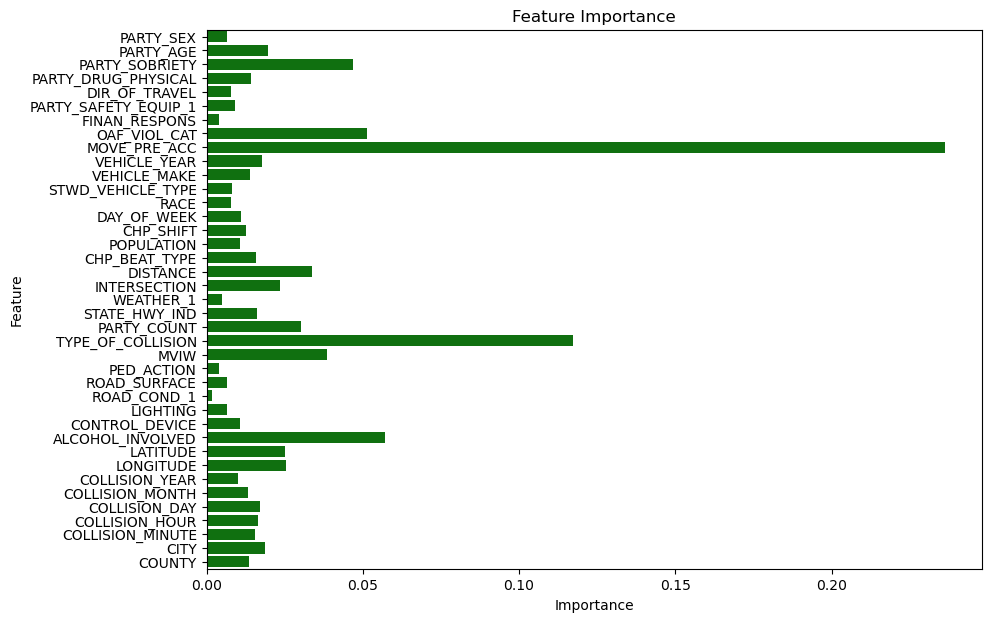

In [33]:
# Create a bar plot
plt.figure(figsize=(10, 7))
sns.barplot(x=importances, y=features, color = 'Green')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [47]:
# check features with low importance
for feature, importance in sorted_importances:
    print(f"{feature}: {importance<.025}")

MOVE_PRE_ACC: False
TYPE_OF_COLLISION: False
ALCOHOL_INVOLVED: False
OAF_VIOL_CAT: False
PARTY_SOBRIETY: False
MVIW: False
DISTANCE: False
PARTY_COUNT: False
LONGITUDE: False
LATITUDE: False
INTERSECTION: True
PARTY_AGE: True
CITY: True
VEHICLE_YEAR: True
COLLISION_DAY: True
COLLISION_HOUR: True
STATE_HWY_IND: True
CHP_BEAT_TYPE: True
COLLISION_MINUTE: True
PARTY_DRUG_PHYSICAL: True
VEHICLE_MAKE: True
COUNTY: True
COLLISION_MONTH: True
CHP_SHIFT: True
DAY_OF_WEEK: True
POPULATION: True
CONTROL_DEVICE: True
COLLISION_YEAR: True
PARTY_SAFETY_EQUIP_1: True
STWD_VEHICLE_TYPE: True
RACE: True
DIR_OF_TRAVEL: True
ROAD_SURFACE: True
LIGHTING: True
PARTY_SEX: True
WEATHER_1: True
PED_ACTION: True
FINAN_RESPONS: True
ROAD_COND_1: True


In [7]:
# drop columns with low importance
# some columns with low importance will not be dropped because they will be needed in the user interface

col_to_drop = ['INTERSECTION','PARTY_AGE','VEHICLE_YEAR','STATE_HWY_IND','COLLISION_MINUTE','PARTY_DRUG_PHYSICAL',
               'VEHICLE_MAKE','CHP_SHIFT','POPULATION','CONTROL_DEVICE','COLLISION_YEAR','PARTY_SAFETY_EQUIP_1',
               'STWD_VEHICLE_TYPE','RACE','DIR_OF_TRAVEL','ROAD_SURFACE','LIGHTING','PARTY_SEX','PED_ACTION','FINAN_RESPONS',
               'LONGITUDE','LATITUDE', 'CITY', 'DISTANCE']

reduced_data = processed_data.copy()

reduced_data = reduced_data.drop(col_to_drop, axis = 1)

### Model New Data

In [8]:
# create target and features
y = reduced_data['PCF_VIOL_CATEGORY']
X = reduced_data.drop('PCF_VIOL_CATEGORY', axis = 1)

In [61]:
# split data, random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42) 

In [62]:
# create a validation set and maintain class distribution to perform grid search
X_train_red, X_val, y_train_red, y_val = train_test_split(X_train, y_train, test_size = .30, stratify = y_train, random_state = 42)

In [63]:
# create dictionary for parameters
param_grid = {
              'n_estimators': [450,500,550],
              'min_samples_split':[2,3,4]
             }
grid_search_cv_rf3 = GridSearchCV(RandomForestClassifier(random_state=42, max_depth = 32),
                              param_grid, scoring ='f1_weighted', verbose=5, cv=2)
%time grid_search_cv_rf3.fit(X_val, np.array(y_val).flatten())
print("The best parameters are: ", grid_search_cv_rf3.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END min_samples_split=2, n_estimators=450;, score=0.807 total time= 2.1min
[CV 2/2] END min_samples_split=2, n_estimators=450;, score=0.809 total time= 2.0min
[CV 1/2] END min_samples_split=2, n_estimators=500;, score=0.807 total time= 2.3min
[CV 2/2] END min_samples_split=2, n_estimators=500;, score=0.809 total time= 2.3min
[CV 1/2] END min_samples_split=2, n_estimators=550;, score=0.807 total time= 2.5min
[CV 2/2] END min_samples_split=2, n_estimators=550;, score=0.809 total time= 2.5min
[CV 1/2] END min_samples_split=3, n_estimators=450;, score=0.808 total time= 2.0min
[CV 2/2] END min_samples_split=3, n_estimators=450;, score=0.810 total time= 2.1min
[CV 1/2] END min_samples_split=3, n_estimators=500;, score=0.808 total time= 2.2min
[CV 2/2] END min_samples_split=3, n_estimators=500;, score=0.810 total time= 2.2min
[CV 1/2] END min_samples_split=3, n_estimators=550;, score=0.808 total time= 2.4min
[CV 2/2] END min

In [64]:
# fit model with tuned hyperparameters
# instanciate object
rfc_red = RandomForestClassifier(min_samples_split = 4, max_depth = 32, n_estimators = 550, random_state = 42)

# fit data
rfc_red.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, min_samples_split=4, n_estimators=550,
                       random_state=42)

In [65]:
# make predictions with reduced data
preds_rfc_red = rfc_red.predict(X_test)

In [66]:
# rfc evaluation metrics
accuracy = accuracy_score(y_test, preds_rfc_red)
precision = precision_score(y_test, preds_rfc_red, average = 'weighted', zero_division=1)
recall = recall_score(y_test, preds_rfc_red, average = 'weighted', zero_division=1)
f1 = f1_score(y_test, preds_rfc_red, average = 'weighted', zero_division=1)

print(f'Random Forest: \n Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n F1: {f1}')

Random Forest: 
 Accuracy: 0.8289375550884805 
 Precision: 0.8216496617710343 
 Recall: 0.8289375550884805 
 F1: 0.818311190657061


Since the precisions, recall and F1 score weren't severely impacted, this will be the final model so the user interface can have fewer inputs going into the model. This will also help since some previous features are less relevant to the primary collision factor such as age and sex.

In [67]:
# select and export final model
finalmodel = rfc_red

joblib.dump(finalmodel, 'finalmodelcomp.pkl', compress = 1)

['finalmodel.pkl']

### Import and Test Model

In [40]:
# view encodings for categorical values
col = 'COUNTY' 

original_classes = encoder_mappings[col]
original_to_encoded = {original: index for index, original in enumerate(original_classes)}
print(f"Original to Encoded mapping for {col}:", original_to_encoded)


Original to Encoded mapping for COUNTY: {'Alameda': 0, 'Alpine': 1, 'Amador': 2, 'Butte': 3, 'Calaveras': 4, 'Colusa': 5, 'Contra Costa': 6, 'Del Norte': 7, 'El Dorado': 8, 'Fresno': 9, 'Glenn': 10, 'Humboldt': 11, 'Imperial': 12, 'Inyo': 13, 'Kern': 14, 'Kings': 15, 'Lake': 16, 'Lassen': 17, 'Los Angeles': 18, 'Madera': 19, 'Marin': 20, 'Mariposa': 21, 'Mendocino': 22, 'Merced': 23, 'Modoc': 24, 'Mono': 25, 'Monterey': 26, 'Napa': 27, 'Nevada': 28, 'Orange': 29, 'Placer': 30, 'Plumas': 31, 'Riverside': 32, 'Sacramento': 33, 'San Benito': 34, 'San Bernardino': 35, 'San Diego': 36, 'San Francisco': 37, 'San Joaquin': 38, 'San Luis Obispo': 39, 'San Mateo': 40, 'Santa Barbara': 41, 'Santa Clara': 42, 'Santa Cruz': 43, 'Shasta': 44, 'Sierra': 45, 'Siskiyou': 46, 'Solano': 47, 'Sonoma': 48, 'Stanislaus': 49, 'Sutter': 50, 'Tehama': 51, 'Trinity': 52, 'Tulare': 53, 'Tuolumne': 54, 'Ventura': 55, 'Yolo': 56, 'Yuba': 57}


In [2]:
# open file
file = open("finalmodelcomp.pkl", "rb")

# load trained model
trained_model = joblib.load(file)

In [12]:
# create data frame for predictions
data = pd.DataFrame({'PARTY_SOBRIETY': [0], 'OAF_VIOL_CAT': [3], 'MOVE_PRE_ACC': [0], 'DAY_OF_WEEK': [3],
                     'CHP_BEAT_TYPE': [4], 'WEATHER_1': [3], 'PARTY_COUNT': [1],
                     'TYPE_OF_COLLISION': [1], 'MVIW': [3], 'ROAD_COND_1': [2], 'ALCOHOL_INVOLVED': [0],
                     'COLLISION_MONTH': [12], 'COLLISION_DAY': [12], 'COLLISION_HOUR':[13], 'COUNTY': [0] })

In [13]:
# get predictions for data
prediction = trained_model.predict(data)

In [16]:
print(f"The model predicts that the primary collision factor will be {prediction}.")

The model predicts that the primary collision factor will be [3].


This is the end of this notebook.